In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import datetime as dt

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

# Modèle boite noire 02

## Transformé de Fourier

In [632]:
def model02_apply( h_M, eta_M,  T_ext, Phi, sample_freq=15*60 ):
    """ T_ext : np_array
        sample_freq : duré entre les points, en seconde
    """
    # TF (reel)
    TF_ext = np.fft.rfft( T_ext  )
    TF_phi = np.fft.rfft( Phi  )
    freq = np.fft.rfftfreq( T_ext.size, d=sample_freq)
    
    # modele
    
    source = h_M * TF_ext + eta_M * TF_phi
    divide = 2j*np.pi*freq + h_M
    TF_theo = source/divide

    # TF inverse
    T_theo = np.fft.irfft( TF_theo , n=T_ext.size )
    
    return T_theo

## Fit

In [633]:
from scipy.optimize import minimize

def errorfit( param, T_int, T_ext, phi  ):
    T_theo = model02_apply( *param, T_ext, phi )
    return np.sum( (T_int - T_theo)**2 )
  

def model01_fit( T_int, T_ext, Phi ):
    
    betaZero = 0.00001, 0.000000001

    res = minimize(errorfit, betaZero, args=(T_int, T_ext, Phi), options={'disp':True})
 
    return res

## Chargement des données

In [4]:
df_full  = pd.read_pickle( 'weatherdata.pck' )

In [5]:
df = df_full[['T_int', 'temperature', 'flux_tot', 'windSpeed']].copy()
df = df.dropna()    

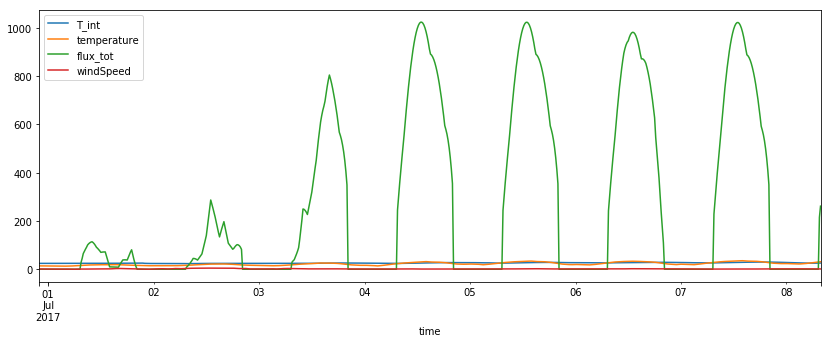

In [6]:
df.plot( figsize=(14, 5) )

In [637]:
# To array :
T_ext = df['temperature'].as_matrix().flatten()
T_int = df['T_int'].as_matrix().flatten()
Phi = df['flux_tot'].as_matrix().flatten()

time_sec = df.index.astype(np.int64) // 10e9

In [638]:
print( T_ext.mean() )
print( T_int.mean() )

22.423988764
25.9544065119


In [639]:
res = model01_fit( T_int, T_ext, Phi )
print( res.x )

         Current function value: 3462.103946
         Iterations: 4
         Function evaluations: 192
         Gradient evaluations: 45
[  4.42584169e-06   7.68752740e-08]


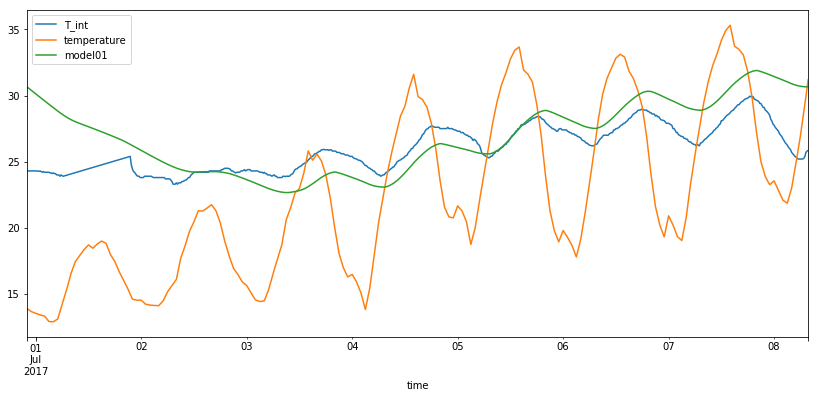

In [640]:
h_M, eta_M = res.x
T_theo = model02_apply(  h_M, eta_M,  T_ext, Phi )

df['model01'] = T_theo

df[['T_int', 'temperature', 'model01']].plot( figsize=(14, 6)  )

# Ode

In [9]:
from scipy.integrate import odeint

In [10]:
def get_dTdt(  T, t, params, get_Text, get_Phi ):
    
    T_ext  = get_Text( t )
    phi = get_Phi( t ) / 100
    
    dTdt = params[0] * ( T_ext - T ) + params[1] * phi
    
    return 1e-6*dTdt

def apply_model( data, T_start, params, full_output=False ):

    data_dict = data.to_dict(orient='list')
    time_sec = data.index.astype(np.int64) // 10e9

    get_Text = lambda t: np.interp( t, time_sec, data_dict['temperature'] )
    get_Phi  = lambda t: np.interp( t, time_sec, data_dict['flux_tot'] )

    T_theo = odeint(get_dTdt, T_start, time_sec, args=(params, get_Text, get_Phi  ), \
                full_output=full_output, h0=30*60) #, rtol=1e-2, atol=1e-2, h0=1200)

    return T_theo.flatten()

In [12]:
from scipy.optimize import minimize
from scipy.optimize import fmin


def get_errorfit( params, data, T_start    ):

    T_exp = data['T_int'].as_matrix()
    T_theo = apply_model( data, T_start, params )
    
    return np.sum( (T_exp - T_theo)**2 )
  

def fit_model( data, T_start ):
    
    params_init =  ( 110  , 60)

    bounds = [(1, 500), (0, 500)]
    #res = minimize(get_errorfit, params_init, args=( data, T_start ) , method='L-BFGS-B',\
    #              options={'disp':True, 'ftol':1e-2}, bounds = bounds) # 
    
    res = fmin(get_errorfit, params_init, args=( data, T_start ) )
                   
    return res

4181.09905764


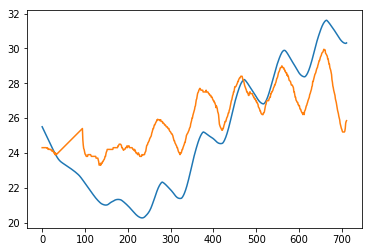

In [13]:
params =  ( 50  , 80)

print( get_errorfit( params, df, 25.5  ) )

res = apply_model( df, 25.5, params )

plt.plot( res )
plt.plot( df['T_int'].as_matrix() )

# Jour par jour

In [20]:
"""  on distingue le fit suivant la nuit ou le jour
        pour ne fitter qu'un seul paramètre
"""
from scipy.optimize import fminbound


def fit_model_p1( data, T_start, param_0  ):
    func0 = lambda x: get_errorfit( (param_0, x), data, T_start  )
    x1, x2 = (.1, 1000)
    param_1 = fminbound(func0, x1, x2, disp=0)
    #param_1 = fmin(func0, 20)

    return param_1

def fit_model_p0( data, T_start, param_1 ):
    func1 = lambda x: get_errorfit( (x, param_1), data, T_start  )
    x1, x2 = (.1, 1000)
    param_0 = fminbound(func1, x1, x2, disp=0)
    #param_0 = fmin(func1, 20)
    
    return param_0

### Groupy by night/day

In [21]:
df['isnight'] = ( df['flux_tot'] == 0 ).astype(int)

nights_days = df['isnight'].diff().abs().cumsum()
nights_days[0] = 0

df_byday  = df.groupby(nights_days) 

Groupes = [ int( k ) for k in df_byday.groups.keys() ]

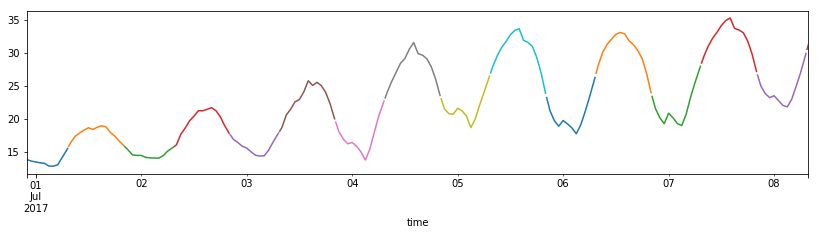

In [22]:
df_byday['temperature'].plot( figsize=(14, 3) );

### Fit group by group

In [32]:
def fit_a_day( data, T_zero ):
    eta_night = 0
    h_day = 20   # fit ? ... mais comment distinguer phi / T_ext en journée ?

    if  data['isnight'].all():
        h = fit_model_p0( data, T_zero, eta_night )
        eta = eta_night
    else:
        h = h_day
        eta = fit_model_p1( data, T_zero, h_day )
        
    res = apply_model( data, T_zero, (h, eta) )
    
    return  (h, eta), res

### For one day

2017-07-03 07:30:00
(20, 143.52175112511642)


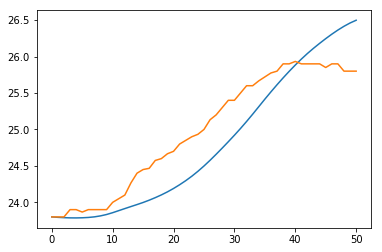

In [33]:
data = df_byday.get_group(  Groupes[5] ) 
T_zero = data['T_int'][0]

params, res = fit_a_day( data, T_zero )

print( data.index[0] )
print( params )

plt.plot( res )
plt.plot( data['T_int'].as_matrix() );

### Loop

In [ ]:
df['T_theo'] = df['T_int'][0]
df['eta_M'], df['h_M'] = 0, 0

T_zero = df['T_int'][0]

for grp_id in Groupes:
    print( '%i, ' % grp_id, end='' )
    data_day = df_byday.get_group(  grp_id ) 
    params, res = fit_a_day( data_day, T_zero )
    
    df.loc[ data_day.index, 'T_theo'] =  res
    df.loc[ data_day.index, 'eta_M'] =  params[1]
    df.loc[ data_day.index, 'h_M'] =  params[0]

    T_zero = res[-1]

print('done')

0, 

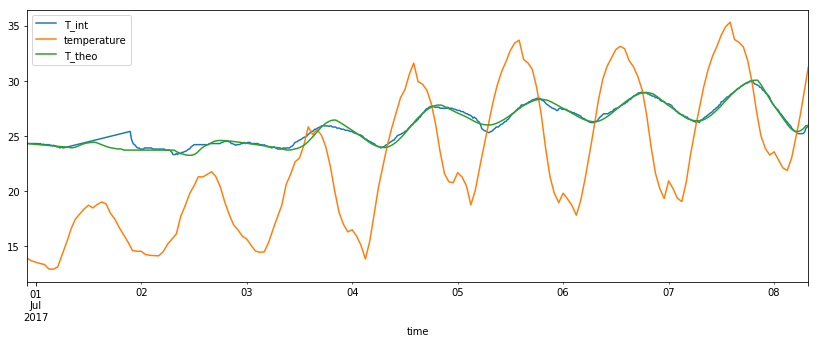

In [26]:
df[['T_int', 'temperature', 'T_theo']].plot( figsize=(14, 5)  )

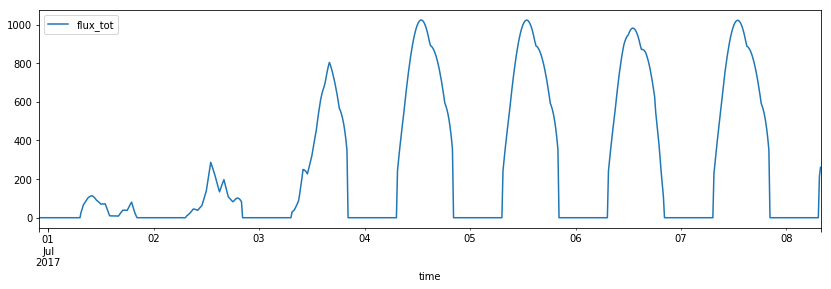

In [28]:
df[['flux_tot']].plot( figsize=(14, 4)  )

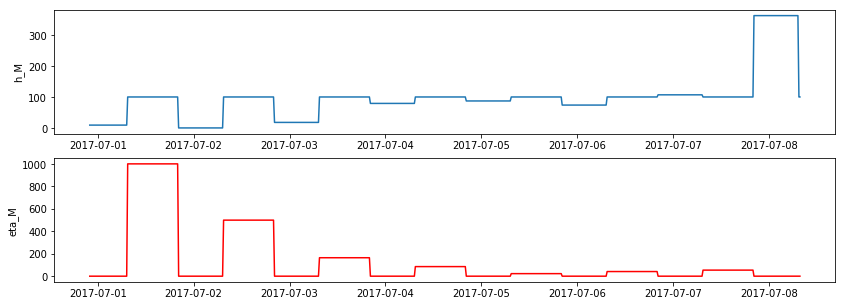

In [31]:
plt.figure( figsize=(14, 5) )
plt.subplot( 2, 1, 1 )
plt.plot( df[['h_M']] ); plt.ylabel('h_M');

plt.subplot( 2, 1, 2 )
plt.plot( df[['eta_M']], 'r' ); plt.ylabel('eta_M');